# Курс орнитологии

1. Реализуйте модель для извлечения признаков из голоса птиц. За основу можно брать:
   - преобразование в аудиофичи (например как mfcc в лекции. Конкретно это преобразование использовать нельзя)
   - обученные поверх аудиофич ML модели
  
1. С помощью модели и одного из предложенных датасетов создайте эмбеддинги пения птиц. Создайте эмбеддинги нескольких записей каждого вида птиц. Визуализируйте эмбеддинги. Для визуализации рекомендуется использовать подмножество видов птиц

1. Аргументируйте почему ваша модель хорошо извлекает признаки из аудио. 
    - Покажите кластеризацию эмбеддингов по видам

1. С помощью эмбеддингов найдите похожие по звучанию виды птиц. Выведите примеры их пения в ноутбуке.



Датасеты:
1. [Датасет](https://www.kaggle.com/vinayshanbhag/bird-song-data-set) американских птиц
1. Почищенный от фонового шума BirdCall [датасет](https://www.kaggle.com/luisblanche/birdcall-singing-3)
1. [Датасет](https://www.kaggle.com/luisblanche/birdcall-singing-0) BirdCall часть 1

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import IPython
from scipy.fft import fft, fftfreq
import pickle
import torchaudio
import torch
import umap

In [2]:
IPython.display.Audio("./data/wavfiles/11713-0.wav")

In [3]:
df = pd.read_csv("./data/bird_songs_metadata.csv")
df.head()

id       genus   species subspecies           name  \
0  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
1  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
2  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
3  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
4  557838  Thryomanes  bewickii        NaN  Bewick's Wren   

                recordist        country  \
0  Whitney Neufeld-Kaiser  United States   
1  Whitney Neufeld-Kaiser  United States   
2  Whitney Neufeld-Kaiser  United States   
3  Whitney Neufeld-Kaiser  United States   
4  Whitney Neufeld-Kaiser  United States   

                                  location  latitude  longitude altitude  \
0  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
1  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
2  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
3  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
4  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   

                   sound_type                   source_url  \
0  adult, sex uncertain, song  //www.xeno-canto.org/557838   
1  adult, sex uncertain, song  //www.xeno-canto.org/557838   
2  adult, sex uncertain, song  //www.xeno-canto.org/557838   
3  adult, sex uncertain, song  //www.xeno-canto.org/557838   
4  adult, sex uncertain, song  //www.xeno-canto.org/557838   

                                        license   time        date  \
0  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
1  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
2  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
3  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
4  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   

                                             remarks      filename  
0  Recorded with Voice Record Pro on iPhone7, nor...  557838-0.wav  
1  Recorded with Voice Record Pro on iPhone7, nor...  557838-1.wav  
2  Recorded with Voice Record Pro on iPhone7, nor...  557838-4.wav  
3  Recorded with Voice Record Pro on iPhone7, nor...  557838-5.wav  
4  Recorded with Voice Record Pro on iPhone7, nor...  557838-6.wav

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


In [5]:
df.genus.unique()

array(['Thryomanes', 'Mimus', 'Turdus', 'Melospiza', 'Cardinalis'],
      dtype=object)

In [6]:
colors_map = {"Thryomanes" : "red", "Mimus" : "green", "Turdus" : "blue", "Melospiza" : "yellow", "Cardinalis" : "black"}

In [32]:
def make_rms(audio):
    x = librosa.feature.rms(y=audio.numpy())
    x = torch.from_numpy(x)
    return torch.reshape(x, (-1, ))

In [33]:
from librosa.feature import mfcc

def make_mels(audio: torch.Tensor) -> torch.Tensor:
    mels = mfcc(audio.numpy())
    mels = torch.from_numpy(mels)
    mels = mels.mean(dim=1)
    return mels

In [35]:
speechs = []
filenames = df.filename.tolist()
path = "./data/wavfiles/"
for filename in filenames:
    wave, sample_rate = librosa.load(path + filename)
    speechs.append(torch.Tensor(wave))

tensor([[0.0766, 0.0884, 0.0934, 0.0904, 0.0944, 0.0841, 0.0757, 0.0799, 0.0819,
         0.0882, 0.1051, 0.1064, 0.1067, 0.1100, 0.1151, 0.1172, 0.1238, 0.1194,
         0.1104, 0.1103, 0.1141, 0.1196, 0.1063, 0.1079, 0.1039, 0.1259, 0.1326,
         0.1298, 0.1286, 0.1195, 0.1224, 0.1197, 0.1118, 0.1004, 0.1096, 0.1144,
         0.1221, 0.1265, 0.1273, 0.1424, 0.1429, 0.1369, 0.1533, 0.1610, 0.1650,
         0.1642, 0.1518, 0.1584, 0.1720, 0.1764, 0.1671, 0.1643, 0.1569, 0.1672,
         0.1683, 0.1523, 0.1724, 0.1756, 0.1832, 0.1810, 0.1937, 0.1857, 0.1945,
         0.1917, 0.1461, 0.1375, 0.1111, 0.1137, 0.1158, 0.1157, 0.1142, 0.1151,
         0.1093, 0.1100, 0.1221, 0.1166, 0.1307, 0.1294, 0.1252, 0.1200, 0.1125,
         0.1152, 0.1125, 0.1184, 0.1123, 0.1086, 0.1068, 0.1102, 0.1118, 0.1129,
         0.1052, 0.1041, 0.1019, 0.1107, 0.1160, 0.1130, 0.1131, 0.1069, 0.1136,
         0.1233, 0.1329, 0.1308, 0.1303, 0.1268, 0.1248, 0.1347, 0.1264, 0.1298,
         0.1373, 0.1366, 0.1

KeyboardInterrupt: 

In [23]:
rms = [make_rms(audio) for audio in speechs]

In [24]:
embs = umap.UMAP().fit_transform(torch.stack(rms))

In [25]:
part1 = df[df.genus == "Thryomanes"].head(100)
part2 = df[df.genus == "Mimus"].head(100)
part3 = df[df.genus == "Turdus"].head(100)
part4 = df[df.genus == "Melospiza"].head(100)
part5 = df[df.genus == "Cardinalis"].head(100)
all_part = pd.concat([part1, part2, part3, part4, part5], ignore_index=True)
cols = list(map(lambda x: colors_map[x], all_part.genus.tolist()))

In [26]:
x = [embs[i, 0] for i in range (1, 500)]
y = [embs[i, 1] for i in range (1, 500)]
colors = [cols[i] for i in range (1, 500)]

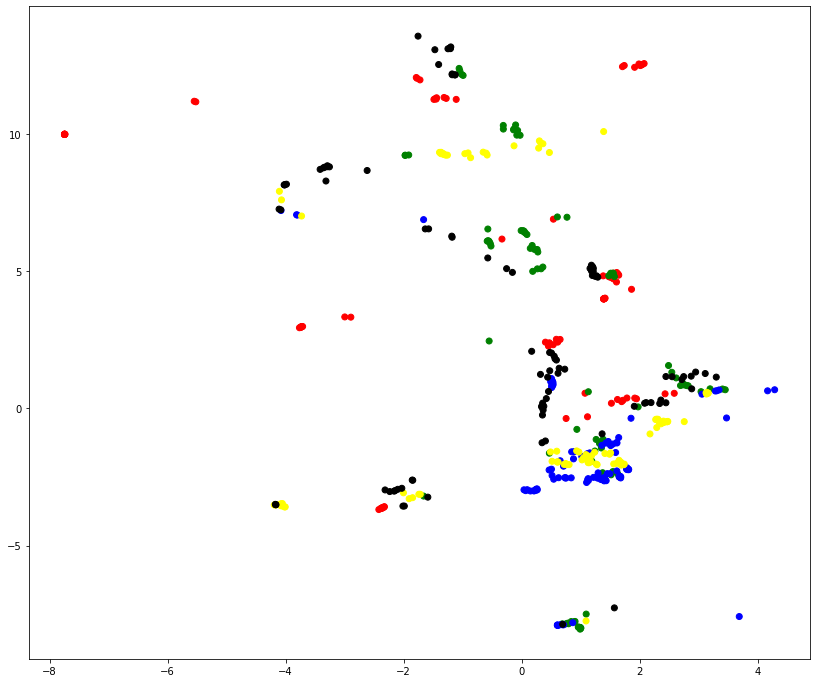

In [27]:
plt.figure(figsize=(14, 12))
plt.scatter(x, y, color=colors)
plt.show()

In [28]:
path = "./data/wavfiles/"
def similar(file):
    wave, sample_rate = librosa.load(path + file)
    vec = make_rms(torch.Tensor(wave)).numpy()
    files = list(df.filename)
    ans = ''
    diff = -float("inf")
    for i in files:
        if i == file:
            continue
        wave, _ = librosa.load(path + i)
        vec2 = make_rms(torch.Tensor(wave)).numpy()
        result = np.dot(vec, vec2) / (np.linalg.norm(vec) * np.linalg.norm(vec2))
        if result > diff:
            diff = result
            ans = i
    return ans

In [29]:
file = "11713-0.wav"
IPython.display.Audio("./data/wavfiles/" + file)

In [30]:
ans = similar(file)
print(ans)
IPython.display.Audio("./data/wavfiles/" + ans)

11713-5.wav
